In [25]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests as rq

import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import operator
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

# re is used for cleaning the dataset 

import re


import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Conv1D,LSTM,GRU,BatchNormalization,Flatten,Dense

## Get the HTML

In [2]:
url = 'https://www.airlinequality.com/airline-reviews/british-airways'

In [3]:
page  = rq.get(url)
print(page)

<Response [200]>


In [4]:
htmlcontent = page.content

## Parse the HTML

In [5]:
soup = BeautifulSoup(htmlcontent, 'html.parser')

In [6]:
body = soup.find_all('article', itemprop = 'review')

In [7]:
type(body)

bs4.element.ResultSet

In [8]:
print(body)

[<article class="comp comp_media-review-rated list-item media position-content review-834045" itemprop="review" itemscope="" itemtype="http://schema.org/Review">
<meta content="2023-02-18" itemprop="datePublished"/>
<div class="rating-10" itemprop="reviewRating" itemscope="" itemtype="http://schema.org/Rating">
<span itemprop="ratingValue">5</span>/<span itemprop="bestRating">10</span>
</div>
<div class="body" id="anchor834045">
<h2 class="text_header">"got virtually free tickets"</h2>
<h3 class="text_sub_header userStatusWrapper">
<span itemprop="author" itemscope="" itemtype="http://schema.org/Person">
<span itemprop="name">Chris Parker</span></span> (United Kingdom) <time datetime="2023-02-18" itemprop="datePublished">18th February 2023</time></h3>
<div class="tc_mobile">
<div class="text_content" itemprop="reviewBody">✅ <strong><a href="https://www.airlinequality.com/verified-reviews/"><em>Trip Verified</em></a></strong> |  Check in was so slow, no self check in and bag drop. Board

In [9]:
global rating, Aircraft, Class, Travel_type, Route, Date, comfort, staff, food, entertainment, wifi, ground_service, vfm, recommend

verified=[]
rating=[]
feedback=[]
Aircraft=[]
Class=[]
Travel_type=[]
Route=[]
Date=[]
comfort=[]
staff=[]
food=[]
entertainment=[]
wifi=[]
ground_service=[]
vfm=[]
recommend=[]

In [10]:
def value_fetcher(soup):
    rating.append(np.nan)
    Aircraft.append(np.nan)
    Class.append(np.nan)
    Travel_type.append(np.nan)
    Route.append(np.nan)
    Date.append(np.nan)
    comfort.append(np.nan)
    staff.append(np.nan)
    food.append(np.nan)
    entertainment.append(np.nan)
    wifi.append(np.nan)
    ground_service.append(np.nan)
    vfm.append(np.nan)
    recommend.append(np.nan)
    
    for row in soup.find_all('tr'):
        header=row.find('td',class_='review-rating-header').text
        value=row.find('td',class_='review-value')
        if header=='Aircraft':
            Aircraft[-1]=value.text
        elif header=='Type Of Traveller':
            Travel_type[-1]=value.text
        elif header=='Seat Type':
            Class[-1]=value.text
        elif header=='Route':
            Route[-1]=value.text
        elif header=='Date Flown':
            Date[-1]=value.text
        elif header=='Seat Comfort':
            comfort[-1]=len(row.find_all('span',class_='star fill'))
        elif header=='Cabin Staff Service':
            staff[-1]=len(row.find_all('span',class_='star fill'))
        elif header=='Food & Beverages':
            food[-1]=len(row.find_all('span',class_='star fill'))
        elif header=='Inflight Entertainment':
            entertainment[-1]=len(row.find_all('span',class_='star fill'))
        elif header=='Ground Service':
            ground_service[-1]=len(row.find_all('span',class_='star fill'))
        elif header=='Value For Money':
            vfm[-1]=len(row.find_all('span',class_='star fill'))
        elif header=='Recommended':
            recommend[-1]=value.text
        elif header=='Wifi & Connectivity':
            wifi[-1]=len(row.find_all('span',class_='star fill'))

In [11]:
def fetcher(soup,tag,key,value):
    if soup.find(tag,{key:value}):
        return soup.find(tag,{key:value}).text
    return np.nan

In [12]:
for i in range(1,344):
    url=f'https://www.airlinequality.com/airline-reviews/british-airways/page/{i}/'
    page=rq.get(url).text
    soup=BeautifulSoup(page,'lxml')
    articles= soup.find_all('article',{'itemprop':'review'})
    for article in articles:
        rating.append(fetcher(article,'span','itemprop','ratingValue'))
        div=article.find('div',class_='tc_mobile')
        content=(div.find('div',class_='text_content').text.split('|'))
        if len(content)==2:
            verification,review=content
        else:
            verification =np.nan
            review=content[0]
        verified.append(verification)
        feedback.append(review)
        table=div.find('table',class_='review-ratings')
        value_fetcher(table)

In [142]:
df=pd.DataFrame({'status':verified,'aircraft':Aircraft,'travel_type':Travel_type,'travel_class':Class,
                   'route':Route,'date':Date,'seating_comfort':comfort,'staff_service':staff,'food_quality':food,
                   'entertainment':entertainment,'wifi':wifi,'ground_service':ground_service,'value_for_money':vfm,
                   'recommended':recommend,'overall_rating':rating[::2],'review':feedback})

In [143]:
df.to_csv('British_Airways.csv',index=False)
df.head(5)

,status,aircraft,travel_type,travel_class,route,date,seating_comfort,staff_service,food_quality,entertainment,wifi,ground_service,value_for_money,recommended,overall_rating,review
0,✅ Trip Verified,A320,Family Leisure,Economy Class,Oslo to London,February 2023,3.0,3.0,1.0,NaN,NaN,2.0,3,no,5,"Check in was so slow, no self check in and b..."
1,✅ Trip Verified,A320,Solo Leisure,Economy Class,London to Madrid,February 2023,2.0,1.0,1.0,NaN,NaN,1.0,2,no,1,My review relates to the appalling experienc...
2,✅ Trip Verified,NaN,Couple Leisure,Economy Class,Islamabad to London,February 2023,4.0,5.0,2.0,3.0,NaN,4.0,5,yes,8,This was my first time flying with BA & I was...
3,✅ Trip Verified,NaN,Couple Leisure,Economy Class,Edinburgh to London,February 2023,3.0,2.0,NaN,NaN,NaN,1.0,1,no,1,Lots of cancellations and delays and no one ...
4,✅ Trip Verified,Boeing 787-9,Couple Leisure,Business Class,Mexico City to London,February 2023,5.0,5.0,4.0,4.0,NaN,5.0,5,yes,9,BA 242 on the 6/2/23. Boarding was delayed du...


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3430 entries, 0 to 3429
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   status           1952 non-null   object 
 1   aircraft         1818 non-null   object 
 2   travel_type      2705 non-null   object 
 3   travel_class     3428 non-null   object 
 4   route            2701 non-null   object 
 5   date             2697 non-null   object 
 6   seating_comfort  3331 non-null   float64
 7   staff_service    3323 non-null   float64
 8   food_quality     3093 non-null   float64
 9   entertainment    2396 non-null   float64
 10  wifi             519 non-null    float64
 11  ground_service   2637 non-null   float64
 12  value_for_money  3430 non-null   int64  
 13  recommended      3430 non-null   object 
 14  overall_rating   3425 non-null   object 
 15  review           3430 non-null   object 
dtypes: float64(6), int64(1), object(9)
memory usage: 428.9+ KB


In [145]:
df.isnull().sum()

status             1478
aircraft           1612
travel_type         725
travel_class          2
route               729
date                733
seating_comfort      99
staff_service       107
food_quality        337
entertainment      1034
wifi               2911
ground_service      793
value_for_money       0
recommended           0
overall_rating        5
review                0
dtype: int64

In [146]:
df.drop('status', axis = 1, inplace = True)
df.drop('aircraft', axis = 1, inplace = True)
df.drop('route', axis = 1, inplace = True)
df.drop('date', axis = 1, inplace = True)
df.drop('wifi', axis = 1, inplace = True)
df.drop('entertainment', axis = 1, inplace = True)
df.head()

,travel_type,travel_class,seating_comfort,staff_service,food_quality,ground_service,value_for_money,recommended,overall_rating,review
0,Family Leisure,Economy Class,3.0,3.0,1.0,2.0,3,no,5,"Check in was so slow, no self check in and b..."
1,Solo Leisure,Economy Class,2.0,1.0,1.0,1.0,2,no,1,My review relates to the appalling experienc...
2,Couple Leisure,Economy Class,4.0,5.0,2.0,4.0,5,yes,8,This was my first time flying with BA & I was...
3,Couple Leisure,Economy Class,3.0,2.0,NaN,1.0,1,no,1,Lots of cancellations and delays and no one ...
4,Couple Leisure,Business Class,5.0,5.0,4.0,5.0,5,yes,9,BA 242 on the 6/2/23. Boarding was delayed du...


In [147]:
df.duplicated().sum()

55

In [148]:
df.drop_duplicates(inplace = True)
df.head()

,travel_type,travel_class,seating_comfort,staff_service,food_quality,ground_service,value_for_money,recommended,overall_rating,review
0,Family Leisure,Economy Class,3.0,3.0,1.0,2.0,3,no,5,"Check in was so slow, no self check in and b..."
1,Solo Leisure,Economy Class,2.0,1.0,1.0,1.0,2,no,1,My review relates to the appalling experienc...
2,Couple Leisure,Economy Class,4.0,5.0,2.0,4.0,5,yes,8,This was my first time flying with BA & I was...
3,Couple Leisure,Economy Class,3.0,2.0,NaN,1.0,1,no,1,Lots of cancellations and delays and no one ...
4,Couple Leisure,Business Class,5.0,5.0,4.0,5.0,5,yes,9,BA 242 on the 6/2/23. Boarding was delayed du...


In [149]:
df.duplicated().sum()

0

In [150]:
df.travel_type.replace(np.nan, 'NA', inplace = True)

travel_class_mode = df.travel_class.mode()[0]
df.travel_class.replace(np.nan, travel_class_mode, inplace = True)

seating_comfort_mean = df.seating_comfort.mean()
df.seating_comfort.replace(np.nan, round(seating_comfort_mean), inplace = True)

staff_service_mean = df.staff_service.mean()
df.staff_service.replace(np.nan, round(staff_service_mean), inplace = True)

food_quality_mean = df.food_quality.mean()
df.food_quality.replace(np.nan, round(food_quality_mean), inplace = True)

ground_service_mean = df.ground_service.mean()
df.ground_service.replace(np.nan, round(ground_service_mean), inplace = True)

overall_rating_mode = df.overall_rating.mode()[0]
df.overall_rating.replace(np.nan, overall_rating_mode, inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3375 entries, 0 to 3429
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   travel_type      3375 non-null   object 
 1   travel_class     3375 non-null   object 
 2   seating_comfort  3375 non-null   float64
 3   staff_service    3375 non-null   float64
 4   food_quality     3375 non-null   float64
 5   ground_service   3375 non-null   float64
 6   value_for_money  3375 non-null   int64  
 7   recommended      3375 non-null   object 
 8   overall_rating   3375 non-null   object 
 9   review           3375 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 290.0+ KB


In [151]:
df['recommended'].unique()

array(['no', 'yes'], dtype=object)

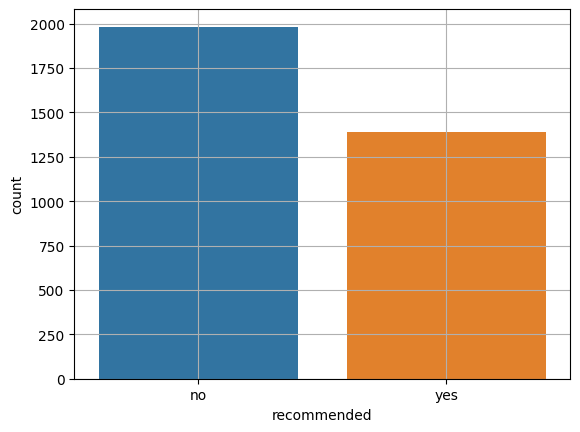

In [152]:
sns.countplot(x=df['recommended'])
plt.grid()

In [153]:
df.head()

,travel_type,travel_class,seating_comfort,staff_service,food_quality,ground_service,value_for_money,recommended,overall_rating,review
0,Family Leisure,Economy Class,3.0,3.0,1.0,2.0,3,no,5,"Check in was so slow, no self check in and b..."
1,Solo Leisure,Economy Class,2.0,1.0,1.0,1.0,2,no,1,My review relates to the appalling experienc...
2,Couple Leisure,Economy Class,4.0,5.0,2.0,4.0,5,yes,8,This was my first time flying with BA & I was...
3,Couple Leisure,Economy Class,3.0,2.0,3.0,1.0,1,no,1,Lots of cancellations and delays and no one ...
4,Couple Leisure,Business Class,5.0,5.0,4.0,5.0,5,yes,9,BA 242 on the 6/2/23. Boarding was delayed du...


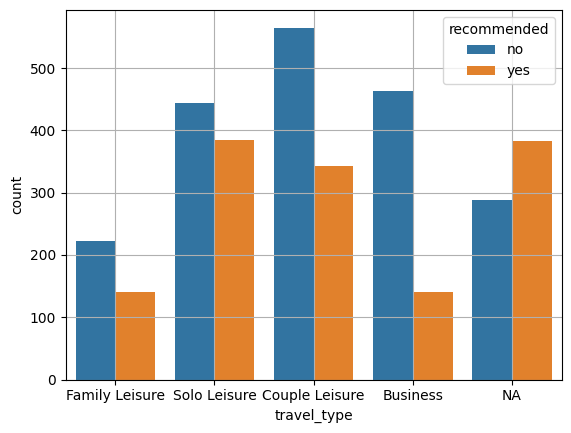

In [154]:
sns.countplot(x=df['travel_type'], hue = df['recommended'] )
plt.grid()

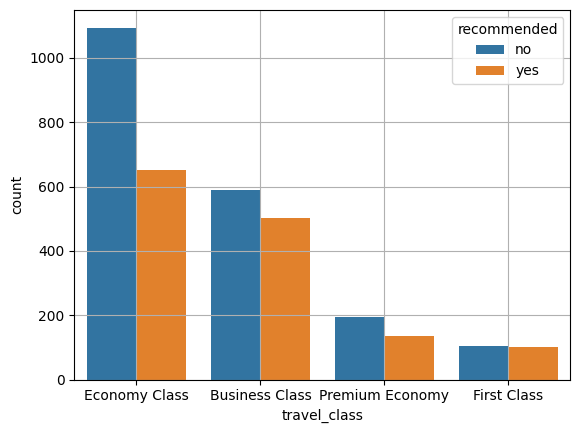

In [155]:
sns.countplot(x=df['travel_class'], hue = df['recommended'] )
plt.grid()

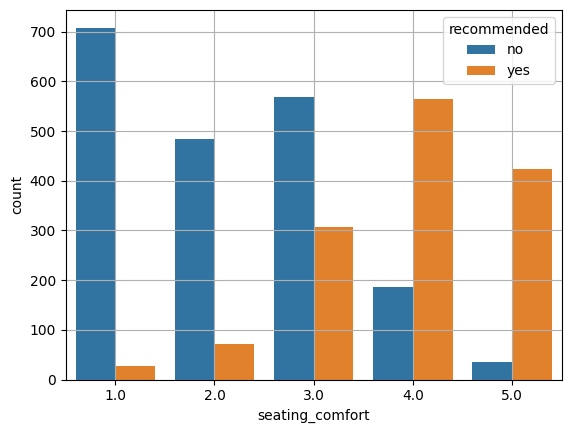

In [156]:
sns.countplot(x=df['seating_comfort'], hue = df['recommended'] )
plt.grid()

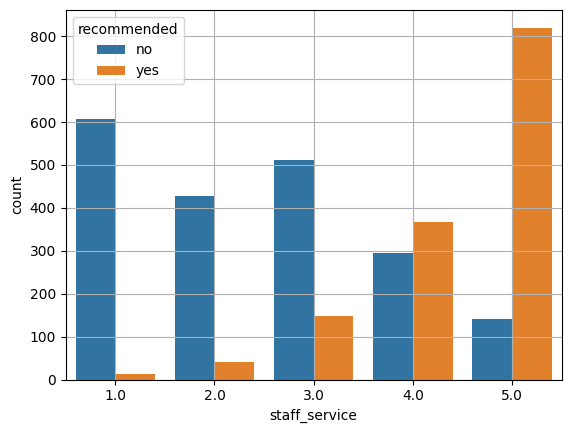

In [157]:
sns.countplot(x=df['staff_service'], hue = df['recommended'] )
plt.grid()

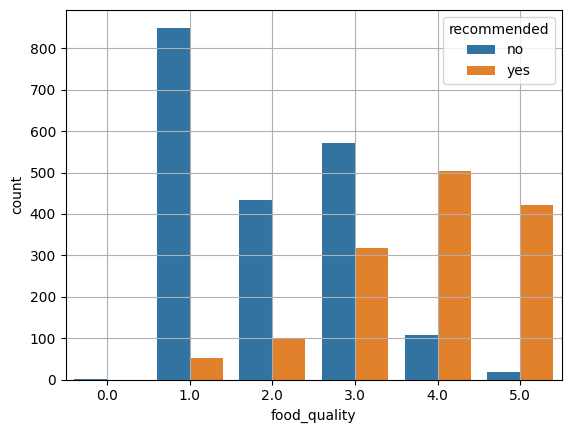

In [158]:
sns.countplot(x=df['food_quality'], hue = df['recommended'] )
plt.grid()

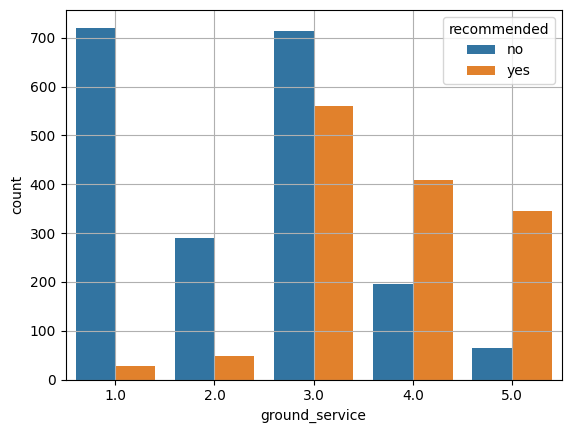

In [159]:
sns.countplot(x=df['ground_service'], hue = df['recommended'])
plt.grid()

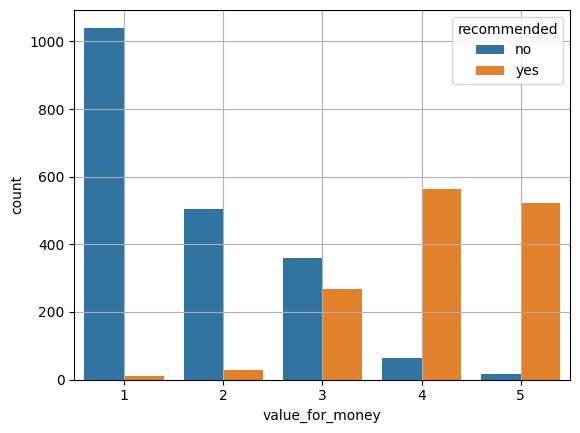

In [160]:
sns.countplot(x=df['value_for_money'], hue = df['recommended'])
plt.grid()

C:\Users\viren\AppData\Local\Temp\ipykernel_24760\253649093.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<AxesSubplot: >

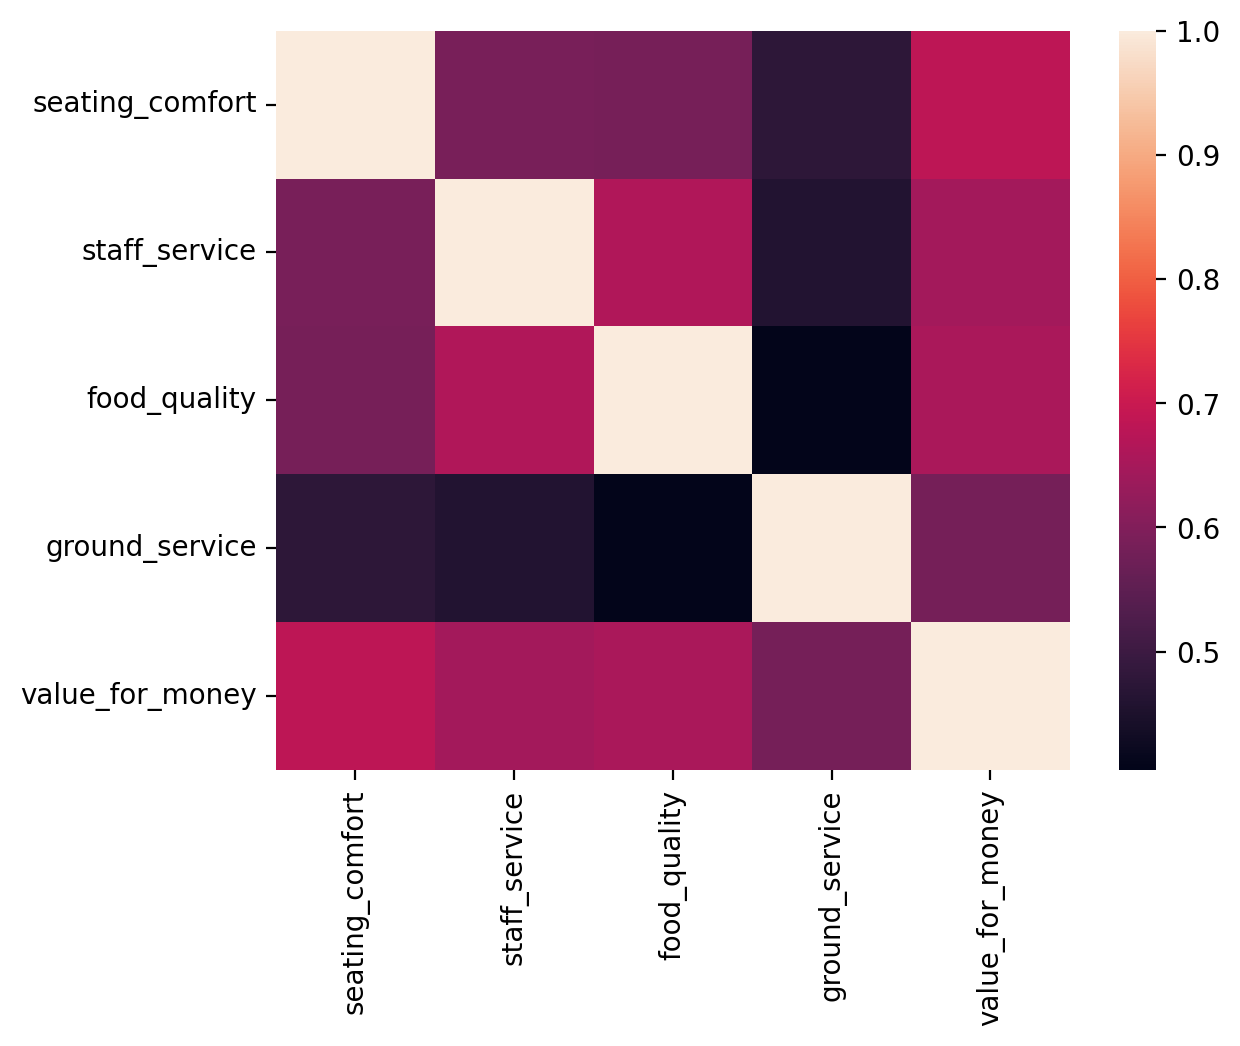

In [161]:
plt.figure(dpi=200)
sns.heatmap(df.corr())

In [162]:
sentences=df['review']
le=LabelEncoder()
df['recommended']= le.fit_transform(df['recommended'])

In [163]:
df.head()
# Here no is transformed to 0 and yes is transformed to 1

,travel_type,travel_class,seating_comfort,staff_service,food_quality,ground_service,value_for_money,recommended,overall_rating,review
0,Family Leisure,Economy Class,3.0,3.0,1.0,2.0,3,0,5,"Check in was so slow, no self check in and b..."
1,Solo Leisure,Economy Class,2.0,1.0,1.0,1.0,2,0,1,My review relates to the appalling experienc...
2,Couple Leisure,Economy Class,4.0,5.0,2.0,4.0,5,1,8,This was my first time flying with BA & I was...
3,Couple Leisure,Economy Class,3.0,2.0,3.0,1.0,1,0,1,Lots of cancellations and delays and no one ...
4,Couple Leisure,Business Class,5.0,5.0,4.0,5.0,5,1,9,BA 242 on the 6/2/23. Boarding was delayed du...


C:\Users\viren\AppData\Local\Temp\ipykernel_24760\2921843975.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


<AxesSubplot: >

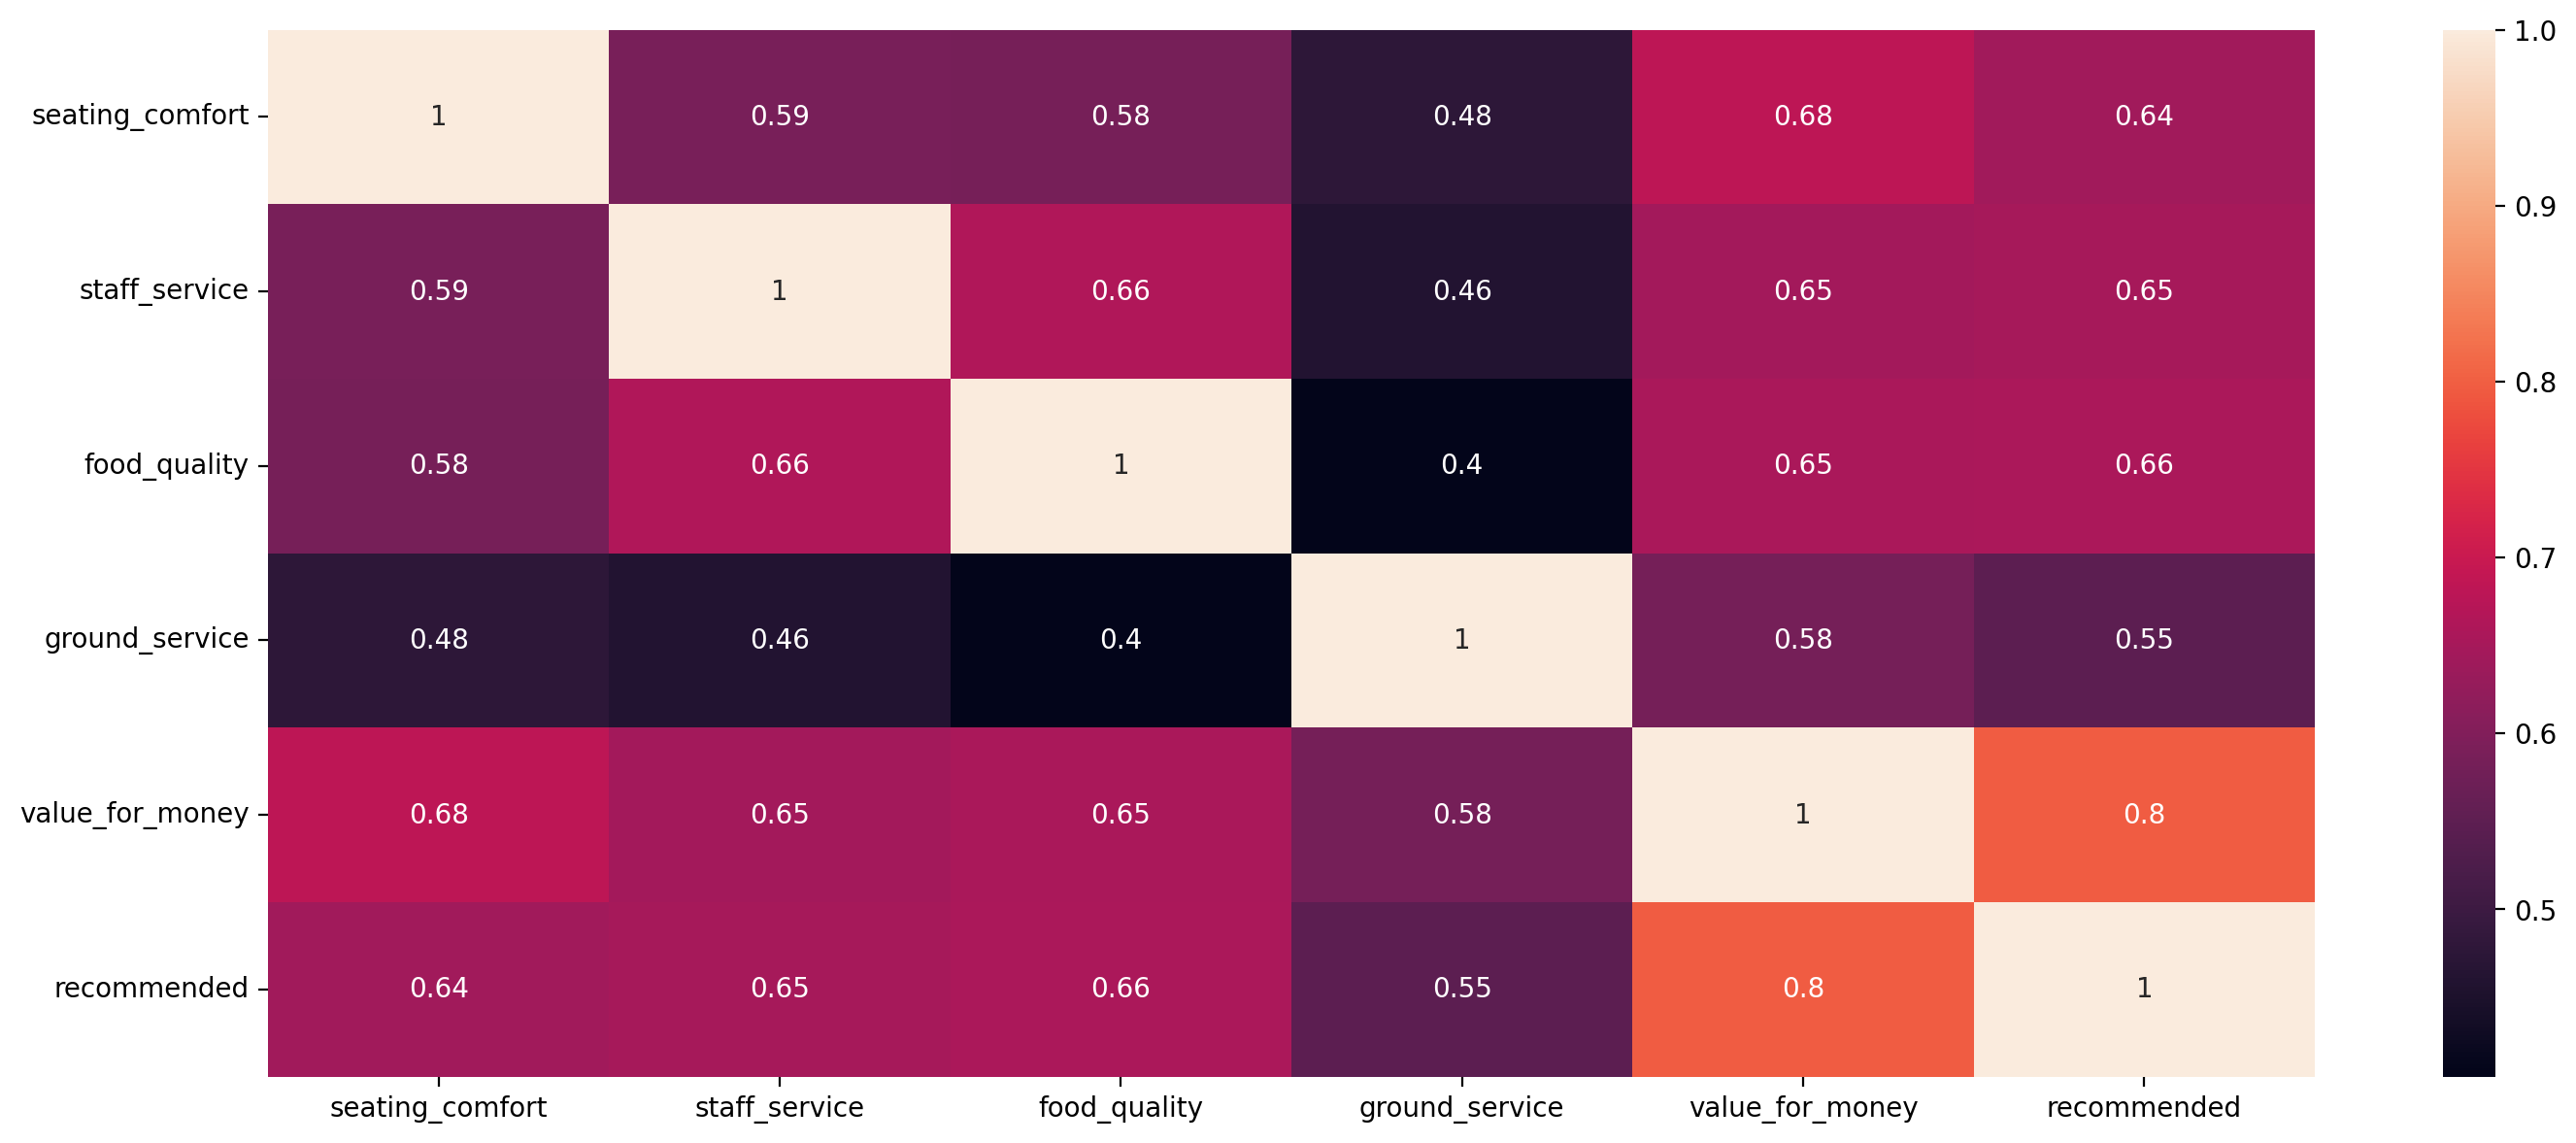

In [165]:
plt.figure(figsize = (17,7), dpi=200)
sns.heatmap(df.corr(), annot = True)

(-0.5, 799.5, 799.5, -0.5)

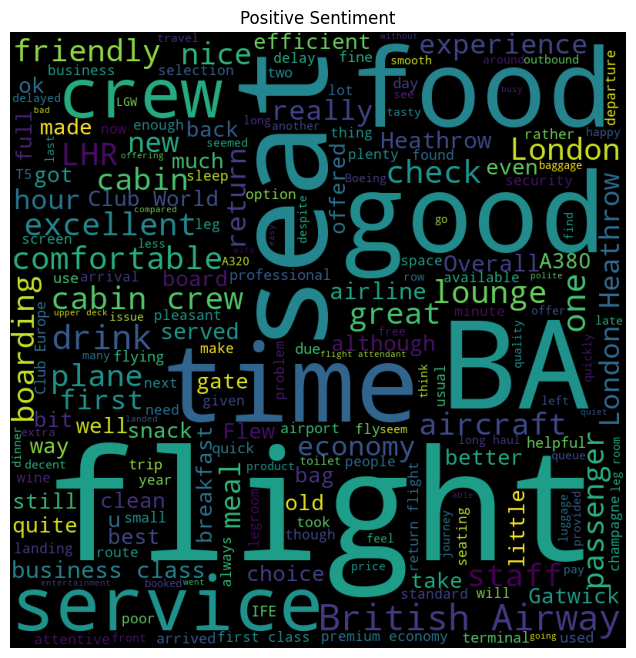

In [167]:
# Data visualization using word cloud for finding the most used words for each type of sentiment
stopwords = set(STOPWORDS) 

pos=' '.join(map(str,sentences[df['recommended']==1]))
neg=' '.join(map(str,sentences[df['recommended']==0]))
  
wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(pos) 

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Positive Sentiment')
plt.axis('off')

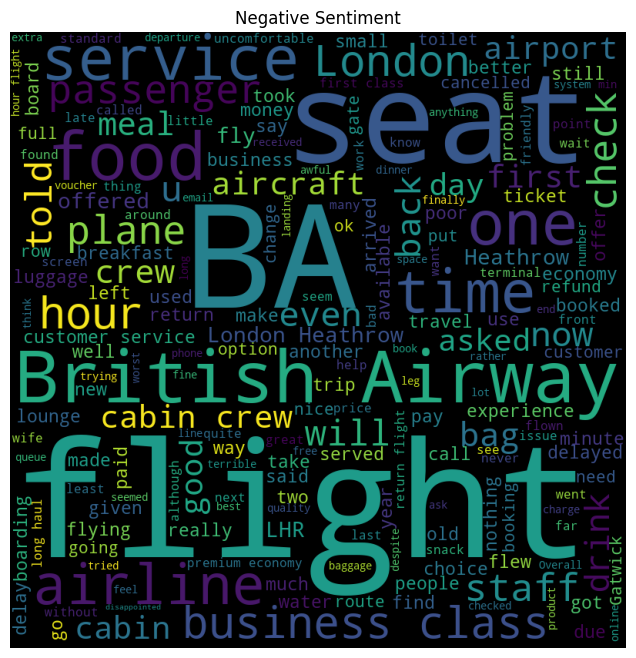

In [168]:
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(neg) 

plt.imshow(wordcloud2)
plt.title('Negative Sentiment')
plt.axis('off')

plt.show() 